In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import logging

### I started by saving the dataset as an .npz file, this way it is easier to transfer it 

In [ ]:
lr_folder = 'Dataset 3A/dataset/LR'
hr_folder = 'Dataset 3A/dataset/HR'

def extract_index(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

lr_files = {extract_index(f): os.path.join(lr_folder, f) for f in os.listdir(lr_folder) if f.endswith('.npy')}
hr_files = {extract_index(f): os.path.join(hr_folder, f) for f in os.listdir(hr_folder) if f.endswith('.npy')}

common_indices = sorted(set(lr_files.keys()) & set(hr_files.keys()))

if not common_indices:
    raise ValueError("No matching samples found between LR and HR folders.")

lr_images = []
hr_images = []

for idx in tqdm(common_indices):
    lr_img = np.load(lr_files[idx])
    hr_img = np.load(hr_files[idx])
    lr_images.append(lr_img)
    hr_images.append(hr_img)

lr_dataset = np.stack(lr_images)
hr_dataset = np.stack(hr_images)

np.savez('3A_lr_hr_dataset.npz', lr=lr_dataset, hr=hr_dataset)

### Loading the dataset 

In [2]:
data = np.load('3A_lr_hr_dataset.npz')
lr_data = data['lr']  
hr_data = data['hr']  


class SuperResDataset(Dataset):
    def __init__(self, lr, hr):
        self.lr = torch.tensor(lr, dtype=torch.float32)
        self.hr = torch.tensor(hr, dtype=torch.float32)

    def __len__(self):
        return len(self.lr)

    def __getitem__(self, idx):
        lr = self.lr[idx]
        hr = self.hr[idx]  
        
        return lr, hr

dataset = SuperResDataset(lr_data, hr_data)

### Let's start with comparing LR, interpolated LR and HR pictures in the dataset

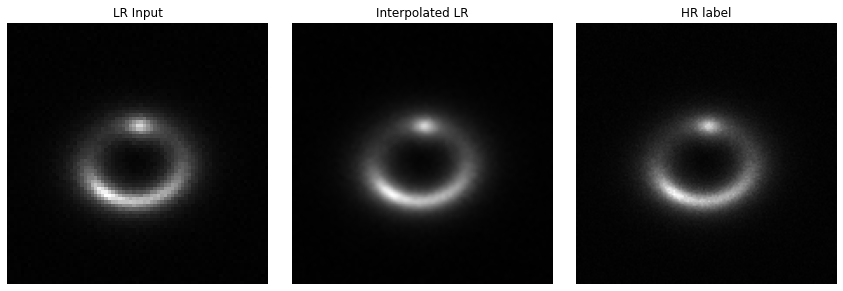

In [3]:
idx = 31
lr, hr = dataset[idx]

lr_img_up = F.interpolate(lr.unsqueeze(0), size=(150, 150), mode='bilinear', align_corners=False)
lr_img = lr.squeeze().numpy()
lr_img_up = lr_img_up.squeeze().numpy()
hr_img = hr.squeeze().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(lr_img, cmap='gray')
axes[0].set_title('LR Input')

axes[1].imshow(lr_img_up, cmap='gray')
axes[1].set_title('Interpolated LR')

axes[2].imshow(hr_img, cmap='gray')
axes[2].set_title('HR label')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### LR and HR pictures actually look very much alike, seems like the resolution bottleneck here is just the number of pixels, not the diffraction
Let's calculate MSE, PSNR and SSIM for the two sets

In [4]:
total_mse = 0
total_psnr = 0
total_ssim = 0
count = 0

for lr_img, hr_img in dataset:

    lr_img, hr_img = lr_img.unsqueeze(0), hr_img.unsqueeze(0)
    lr_img_up = F.interpolate(lr_img, size=(150, 150), mode='bilinear', align_corners=False)
    lr_up_np = lr_img_up.squeeze().cpu().numpy()
    hr_np = hr_img.squeeze().cpu().numpy()

    total_mse  += np.mean((hr_np - lr_up_np) ** 2)
    total_psnr += psnr(hr_np, lr_up_np, data_range=1.0)
    total_ssim += ssim(hr_np, lr_up_np, data_range=1.0)
    count += 1

print("Comparing interpolated LR and HR labels")
print(f"MSE : {total_mse / count:.1e}")
print(f"PSNR: {total_psnr / count:.2f}")
print(f"SSIM: {total_ssim / count:.8f}")

Comparing interpolated LR and HR labels
MSE : 6.9e-05
PSNR: 41.68
SSIM: 0.97567940


### The metrics are already pretty high even without any training. 
Moreover, interpolated LR images actually look smoother than the HR label. The reason for this might be some sort of detection noise (for example shot noise). Let's verify it by plotting the Fourier spectrum of the labels

In [5]:
def radial_average(power_spectrum):
    """
    Computes the radial average of a 2D power spectrum.
    Returns a 1D array where each element is the mean power in a radial bin.
    """
    h, w = power_spectrum.shape
    y, x = np.indices((h, w))
    center = (h // 2, w // 2)

    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)
    r = r.astype(np.int32)

    # Create a mask for each radius
    max_radius = np.min(center)
    radial_mean = np.zeros(max_radius)

    for radius in range(max_radius):
        mask = r == radius
        if np.any(mask):
            radial_mean[radius] = power_spectrum[mask].mean()

    return radial_mean
def compute_average_fourier_spectrum(images):
    """
    Computes the radial average Fourier spectrum of a list or array of images.
    Expects images of shape (H, W) or (N, H, W)
    """
    spectra = []
    for img in images:
        if img.ndim == 3:  # (1, H, W)
            img = img.squeeze()
        fft = np.fft.fft2(img)
        fft_shifted = np.fft.fftshift(fft)
        power = np.abs(fft_shifted) ** 2
        radial_profile = radial_average(power)
        spectra.append(radial_profile)
    return np.mean(spectra, axis=0)

def plot_average_spectrum(images, label='Spectrum', color=None, freq_cutoff=50):
    avg_spectrum = compute_average_fourier_spectrum(images)

    # Truncate to cutoff
    freqs = np.arange(len(avg_spectrum))
    plt.plot(freqs[:freq_cutoff], avg_spectrum[:freq_cutoff], label=label, color=color)
    plt.xlabel('Frequency (radial bins)')
    plt.ylabel('Average Power')
    plt.yscale('log')
    plt.title(f'Fourier Spectrum (0–{freq_cutoff})')
    plt.grid(True)
    plt.legend()

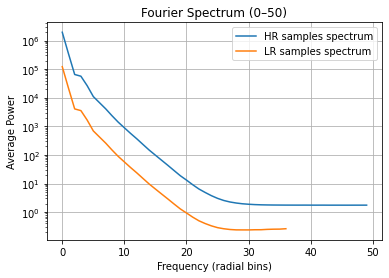

In [6]:
hr_images = []
lr_images = []

for lr_img, hr_img in dataset:
    hr_np = hr_img.squeeze().cpu().numpy()
    hr_images.append(hr_np)

    lr_np = lr_img.squeeze().cpu().numpy()
    lr_images.append(lr_np)

plot_average_spectrum(hr_images, label = "HR samples spectrum")
plot_average_spectrum(lr_images, label = "LR samples spectrum")

### We can see that everything with frequencies higher than 30-35 is definetely noise
Which means it cannot be learned by the NN as it is random and independent of the LR input. Let's cut off higher frequencies in the label and see how much room for improvement we have

In [7]:
def lowpass_filter(image, cutoff_radius):
    """
    Differentiable low-pass filter in PyTorch
    image: (B, 1, H, W)
    returns: filtered image (same shape)
    """
    B, C, H, W = image.shape

    # Create frequency mask
    y = torch.arange(H, device=image.device).reshape(-1, 1)
    x = torch.arange(W, device=image.device).reshape(1, -1)
    center_y, center_x = (H - 1) / 2, (W - 1) / 2
    dist = torch.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    mask = (dist <= cutoff_radius).float()  # (H, W)
    mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)

    # Forward FFT
    f = torch.fft.fft2(image)
    fshift = torch.fft.fftshift(f)

    # Apply mask
    f_filtered = fshift * mask

    # Inverse FFT
    f_ishift = torch.fft.ifftshift(f_filtered)
    img_filtered = torch.fft.ifft2(f_ishift).real  # discard imaginary

    return img_filtered

In [8]:
cutoff_radius = 35

total_mse = 0
total_psnr = 0
total_ssim = 0
count = 0

for lr_img, hr_img in dataset:

    lr_img, hr_img = lr_img.unsqueeze(0), hr_img.unsqueeze(0)

    hr_img_clean = lowpass_filter(hr_img, cutoff_radius = cutoff_radius)
    lr_img_up = F.interpolate(lr_img, size=(150, 150), mode='bilinear', align_corners=False)
    
    lr_up_np = lr_img_up.squeeze().cpu().numpy()
    hr_np = hr_img_clean.squeeze().cpu().numpy()

    total_mse  += np.mean((hr_np - lr_up_np) ** 2)
    total_psnr += psnr(hr_np, lr_up_np, data_range=1.0)
    total_ssim += ssim(hr_np, lr_up_np, data_range=1.0)
    count += 1

print(f"Comparing interpolated LR and HR labels with applied high-frequency cut-off (cut-off radius: {cutoff_radius})")
print(f"MSE : {total_mse / count:.1e}")
print(f"PSNR: {total_psnr / count:.2f}")
print(f"SSIM: {total_ssim / count:.8f}")

Comparing interpolated LR and HR labels with applied high-frequency cut-off (cut-off radius: 35)
MSE : 1.3e-05
PSNR: 48.87
SSIM: 0.99663967


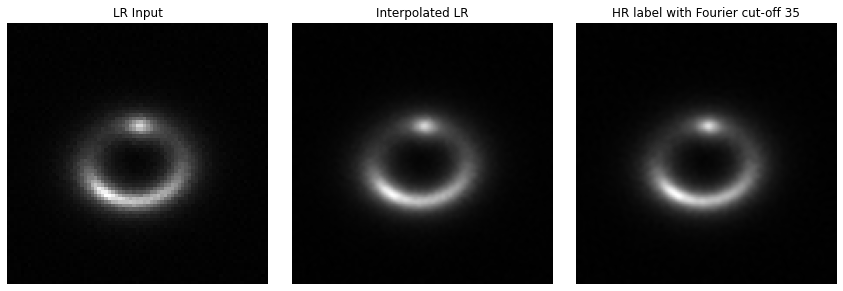

In [9]:
idx = 31
lr, hr = dataset[idx]

lr_img_up = F.interpolate(lr.unsqueeze(0), size=(150, 150), mode='bilinear', align_corners=False)
lr_img = lr.squeeze().numpy()
lr_img_up = lr_img_up.squeeze().numpy()

hr_img_clean = lowpass_filter(hr.unsqueeze(0), cutoff_radius = cutoff_radius)
hr_img_clean = hr_img_clean.squeeze().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(lr_img, cmap='gray')
axes[0].set_title('LR Input')

axes[1].imshow(lr_img_up, cmap='gray')
axes[1].set_title('Interpolated LR')

axes[2].imshow(hr_img_clean, cmap='gray')
axes[2].set_title(f'HR label with Fourier cut-off {cutoff_radius}')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Now we can see that there is very little room for improvement, let's still try to train a model
I use U-Net architecture and train it to figure out the residual between the input and label

In [10]:
#train/test split
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

In [11]:
def center_crop(enc_feat, target_feat):
    _, _, h, w = target_feat.shape
    enc_h, enc_w = enc_feat.shape[2], enc_feat.shape[3]
    crop_top = (enc_h - h) // 2
    crop_left = (enc_w - w) // 2
    return enc_feat[:, :, crop_top:crop_top+h, crop_left:crop_left+w]

class DoubleConv(nn.Module):
    """(conv => ReLU) * 2"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoding path
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoding path
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        e3_cropped = center_crop(e3, d3)
        d3 = self.dec3(torch.cat([d3, e3_cropped], dim=1))

        d2 = self.up2(d3)
        e2_cropped = center_crop(e2, d2)
        d2 = self.dec2(torch.cat([d2, e2_cropped], dim=1))

        d1 = self.up1(d2)
        e1_cropped = center_crop(e1, d1)
        d1 = self.dec1(torch.cat([d1, e1_cropped], dim=1))

        out = self.final_conv(d1)
        out = F.interpolate(out, size=(150, 150), mode='bilinear', align_corners=False)
        return x+out

### Some useful functions
- Evaluation and logging

In [12]:
def evaluate_on_test_set(model, test_loader, device='cuda'):
    model.eval()
    total_loss = 0.0
    total_mse = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0

    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            
            lr_imgs = F.interpolate(lr_imgs, size=(150, 150), mode='bilinear', align_corners=False)
            
            preds = model(lr_imgs)

            loss = nn.MSELoss()(preds, hr_imgs)
            total_loss += loss.item()

            preds_np = preds.cpu().numpy()
            hr_np = hr_imgs.cpu().numpy()

            for pred, gt in zip(preds_np, hr_np):
                pred_img = np.squeeze(pred)
                gt_img = np.squeeze(gt)

                total_mse += np.mean((gt_img - pred_img) ** 2)
                total_psnr += psnr(gt_img, pred_img, data_range=1.0)
                total_ssim += ssim(gt_img, pred_img, data_range=1.0)
                count += 1

    avg_loss = total_loss / len(test_loader)
    avg_mse = total_mse /count
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count

    return avg_loss, avg_mse, avg_psnr, avg_ssim

def create_run_dir(base_dir='3A_runs'):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(base_dir, f"run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

def setup_logger(run_dir, log_name='training.log'):
    log_path = os.path.join(run_dir, log_name)
    logging.basicConfig(
        filename=log_path,
        filemode='a',
        format='%(asctime)s - %(message)s',
        level=logging.INFO
    )
    
    def log_and_print(msg):
        print(msg)
        logging.info(msg)
    
    return log_and_print

def log_and_export_metrics(train_losses, test_losses, test_psnrs, test_ssims, run_dir):

    csv_path = os.path.join(run_dir, 'metrics.csv')

    # Plotting
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    # ---- Loss (Log Scale) ----
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    # ---- PSNR ----
    plt.subplot(1, 3, 2)
    plt.plot(epochs, test_psnrs, label='Test PSNR', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Test PSNR Over Epochs')
    plt.grid(True)

    # ---- SSIM ----
    plt.subplot(1, 3, 3)
    plt.plot(epochs, test_ssims, label='Test SSIM', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title('Test SSIM Over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(run_dir, 'metrics_plot.png'))
    plt.close()

    # Save CSV
    import pandas as pd
    df = pd.DataFrame({
        'epoch': epochs,
        'train_loss': train_losses,
        'test_loss': test_losses,
        'psnr': test_psnrs,
        'ssim': test_ssims
    })
    df.to_csv(csv_path, index=False)
    log_and_print(f"Metrics saved to: {csv_path}")

### Initializing the model

In [13]:
model = UNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Training the model

Starting new training run...
Run directory: 3A_runs/run_20250401_185741


Epoch 1/100: 100%|██████████| 282/282 [00:35<00:00,  8.04it/s]


Epoch 1: Train Loss = 9.020e-04 | Test Loss = 6.558e-05 | MSE = 6.553e-05 | PSNR = 41.87 | SSIM = 0.9756


Epoch 2/100: 100%|██████████| 282/282 [00:35<00:00,  7.92it/s]


Epoch 2: Train Loss = 6.570e-05 | Test Loss = 6.463e-05 | MSE = 6.458e-05 | PSNR = 41.94 | SSIM = 0.9758


Epoch 3/100: 100%|██████████| 282/282 [00:35<00:00,  7.84it/s]


Epoch 3: Train Loss = 6.504e-05 | Test Loss = 6.434e-05 | MSE = 6.430e-05 | PSNR = 41.96 | SSIM = 0.9758


Epoch 4/100: 100%|██████████| 282/282 [00:36<00:00,  7.80it/s]


Epoch 4: Train Loss = 6.470e-05 | Test Loss = 6.375e-05 | MSE = 6.371e-05 | PSNR = 41.99 | SSIM = 0.9759


Epoch 5/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 5: Train Loss = 6.406e-05 | Test Loss = 6.346e-05 | MSE = 6.341e-05 | PSNR = 42.01 | SSIM = 0.9759


Epoch 6/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 6: Train Loss = 6.389e-05 | Test Loss = 6.334e-05 | MSE = 6.330e-05 | PSNR = 42.02 | SSIM = 0.9759


Epoch 7/100: 100%|██████████| 282/282 [00:35<00:00,  7.84it/s]


Epoch 7: Train Loss = 6.370e-05 | Test Loss = 6.323e-05 | MSE = 6.319e-05 | PSNR = 42.03 | SSIM = 0.9759


Epoch 8/100: 100%|██████████| 282/282 [00:35<00:00,  7.83it/s]


Epoch 8: Train Loss = 6.363e-05 | Test Loss = 6.311e-05 | MSE = 6.306e-05 | PSNR = 42.04 | SSIM = 0.9758


Epoch 9/100: 100%|██████████| 282/282 [00:35<00:00,  7.83it/s]


Epoch 9: Train Loss = 6.356e-05 | Test Loss = 6.297e-05 | MSE = 6.293e-05 | PSNR = 42.05 | SSIM = 0.9759


Epoch 10/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 10: Train Loss = 6.353e-05 | Test Loss = 6.300e-05 | MSE = 6.296e-05 | PSNR = 42.04 | SSIM = 0.9759


Epoch 11/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 11: Train Loss = 6.348e-05 | Test Loss = 6.294e-05 | MSE = 6.290e-05 | PSNR = 42.05 | SSIM = 0.9759


Epoch 12/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 12: Train Loss = 6.345e-05 | Test Loss = 6.288e-05 | MSE = 6.284e-05 | PSNR = 42.05 | SSIM = 0.9759


Epoch 13/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 13: Train Loss = 6.346e-05 | Test Loss = 6.296e-05 | MSE = 6.292e-05 | PSNR = 42.05 | SSIM = 0.9757


Epoch 14/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 14: Train Loss = 6.343e-05 | Test Loss = 6.282e-05 | MSE = 6.277e-05 | PSNR = 42.06 | SSIM = 0.9759


Epoch 15/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 15: Train Loss = 6.340e-05 | Test Loss = 6.273e-05 | MSE = 6.269e-05 | PSNR = 42.06 | SSIM = 0.9759


Epoch 16/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 16: Train Loss = 6.331e-05 | Test Loss = 6.411e-05 | MSE = 6.407e-05 | PSNR = 41.97 | SSIM = 0.9743


Epoch 17/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 17: Train Loss = 6.306e-05 | Test Loss = 6.242e-05 | MSE = 6.238e-05 | PSNR = 42.08 | SSIM = 0.9759


Epoch 18/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 18: Train Loss = 6.278e-05 | Test Loss = 6.206e-05 | MSE = 6.202e-05 | PSNR = 42.11 | SSIM = 0.9760


Epoch 19/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 19: Train Loss = 6.252e-05 | Test Loss = 6.206e-05 | MSE = 6.202e-05 | PSNR = 42.11 | SSIM = 0.9760


Epoch 20/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 20: Train Loss = 6.211e-05 | Test Loss = 6.140e-05 | MSE = 6.136e-05 | PSNR = 42.16 | SSIM = 0.9762
Saved model at epoch 20 to 3A_runs/run_20250401_185741/model_epoch_20.pth


Epoch 21/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 21: Train Loss = 6.167e-05 | Test Loss = 6.081e-05 | MSE = 6.077e-05 | PSNR = 42.20 | SSIM = 0.9764


Epoch 22/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 22: Train Loss = 6.123e-05 | Test Loss = 6.086e-05 | MSE = 6.083e-05 | PSNR = 42.19 | SSIM = 0.9760


Epoch 23/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 23: Train Loss = 6.094e-05 | Test Loss = 6.091e-05 | MSE = 6.087e-05 | PSNR = 42.19 | SSIM = 0.9759


Epoch 24/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 24: Train Loss = 6.066e-05 | Test Loss = 5.999e-05 | MSE = 5.995e-05 | PSNR = 42.26 | SSIM = 0.9767


Epoch 25/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 25: Train Loss = 6.048e-05 | Test Loss = 5.983e-05 | MSE = 5.979e-05 | PSNR = 42.27 | SSIM = 0.9767


Epoch 26/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 26: Train Loss = 6.033e-05 | Test Loss = 5.969e-05 | MSE = 5.965e-05 | PSNR = 42.28 | SSIM = 0.9768


Epoch 27/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 27: Train Loss = 6.010e-05 | Test Loss = 5.955e-05 | MSE = 5.952e-05 | PSNR = 42.29 | SSIM = 0.9769


Epoch 28/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 28: Train Loss = 6.004e-05 | Test Loss = 5.982e-05 | MSE = 5.978e-05 | PSNR = 42.27 | SSIM = 0.9766


Epoch 29/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 29: Train Loss = 5.994e-05 | Test Loss = 5.940e-05 | MSE = 5.937e-05 | PSNR = 42.30 | SSIM = 0.9770


Epoch 30/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 30: Train Loss = 5.987e-05 | Test Loss = 5.930e-05 | MSE = 5.926e-05 | PSNR = 42.31 | SSIM = 0.9770


Epoch 31/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 31: Train Loss = 5.978e-05 | Test Loss = 5.927e-05 | MSE = 5.923e-05 | PSNR = 42.31 | SSIM = 0.9771


Epoch 32/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 32: Train Loss = 5.973e-05 | Test Loss = 5.930e-05 | MSE = 5.926e-05 | PSNR = 42.31 | SSIM = 0.9770


Epoch 33/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 33: Train Loss = 5.961e-05 | Test Loss = 5.927e-05 | MSE = 5.924e-05 | PSNR = 42.31 | SSIM = 0.9770


Epoch 34/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 34: Train Loss = 5.959e-05 | Test Loss = 5.917e-05 | MSE = 5.913e-05 | PSNR = 42.32 | SSIM = 0.9771


Epoch 35/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 35: Train Loss = 5.954e-05 | Test Loss = 5.903e-05 | MSE = 5.899e-05 | PSNR = 42.33 | SSIM = 0.9772


Epoch 36/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 36: Train Loss = 5.947e-05 | Test Loss = 5.921e-05 | MSE = 5.917e-05 | PSNR = 42.31 | SSIM = 0.9771


Epoch 37/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 37: Train Loss = 5.945e-05 | Test Loss = 5.897e-05 | MSE = 5.893e-05 | PSNR = 42.33 | SSIM = 0.9773


Epoch 38/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 38: Train Loss = 5.939e-05 | Test Loss = 5.898e-05 | MSE = 5.895e-05 | PSNR = 42.33 | SSIM = 0.9773


Epoch 39/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 39: Train Loss = 5.934e-05 | Test Loss = 5.892e-05 | MSE = 5.889e-05 | PSNR = 42.33 | SSIM = 0.9773


Epoch 40/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 40: Train Loss = 5.931e-05 | Test Loss = 5.889e-05 | MSE = 5.885e-05 | PSNR = 42.34 | SSIM = 0.9773
Saved model at epoch 40 to 3A_runs/run_20250401_185741/model_epoch_40.pth


Epoch 41/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 41: Train Loss = 5.928e-05 | Test Loss = 5.886e-05 | MSE = 5.882e-05 | PSNR = 42.34 | SSIM = 0.9774


Epoch 42/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 42: Train Loss = 5.923e-05 | Test Loss = 5.891e-05 | MSE = 5.887e-05 | PSNR = 42.34 | SSIM = 0.9774


Epoch 43/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 43: Train Loss = 5.920e-05 | Test Loss = 5.878e-05 | MSE = 5.874e-05 | PSNR = 42.35 | SSIM = 0.9774


Epoch 44/100: 100%|██████████| 282/282 [00:36<00:00,  7.77it/s]


Epoch 44: Train Loss = 5.921e-05 | Test Loss = 5.885e-05 | MSE = 5.881e-05 | PSNR = 42.34 | SSIM = 0.9774


Epoch 45/100: 100%|██████████| 282/282 [00:37<00:00,  7.55it/s]


Epoch 45: Train Loss = 5.914e-05 | Test Loss = 5.883e-05 | MSE = 5.879e-05 | PSNR = 42.34 | SSIM = 0.9774


Epoch 46/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 46: Train Loss = 5.912e-05 | Test Loss = 5.873e-05 | MSE = 5.869e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 47/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 47: Train Loss = 5.912e-05 | Test Loss = 5.876e-05 | MSE = 5.872e-05 | PSNR = 42.35 | SSIM = 0.9774


Epoch 48/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 48: Train Loss = 5.908e-05 | Test Loss = 5.873e-05 | MSE = 5.869e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 49/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 49: Train Loss = 5.906e-05 | Test Loss = 5.877e-05 | MSE = 5.873e-05 | PSNR = 42.35 | SSIM = 0.9774


Epoch 50/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 50: Train Loss = 5.905e-05 | Test Loss = 5.868e-05 | MSE = 5.864e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 51/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 51: Train Loss = 5.901e-05 | Test Loss = 5.877e-05 | MSE = 5.873e-05 | PSNR = 42.35 | SSIM = 0.9774


Epoch 52/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 52: Train Loss = 5.900e-05 | Test Loss = 5.868e-05 | MSE = 5.864e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 53/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 53: Train Loss = 5.899e-05 | Test Loss = 5.871e-05 | MSE = 5.867e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 54/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 54: Train Loss = 5.897e-05 | Test Loss = 5.863e-05 | MSE = 5.859e-05 | PSNR = 42.36 | SSIM = 0.9775


Epoch 55/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 55: Train Loss = 5.896e-05 | Test Loss = 5.870e-05 | MSE = 5.866e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 56/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 56: Train Loss = 5.894e-05 | Test Loss = 5.862e-05 | MSE = 5.858e-05 | PSNR = 42.36 | SSIM = 0.9775


Epoch 57/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 57: Train Loss = 5.893e-05 | Test Loss = 5.865e-05 | MSE = 5.862e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 58/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 58: Train Loss = 5.891e-05 | Test Loss = 5.857e-05 | MSE = 5.853e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 59/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 59: Train Loss = 5.889e-05 | Test Loss = 5.870e-05 | MSE = 5.865e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 60/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 60: Train Loss = 5.889e-05 | Test Loss = 5.861e-05 | MSE = 5.857e-05 | PSNR = 42.36 | SSIM = 0.9775
Saved model at epoch 60 to 3A_runs/run_20250401_185741/model_epoch_60.pth


Epoch 61/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 61: Train Loss = 5.886e-05 | Test Loss = 5.861e-05 | MSE = 5.857e-05 | PSNR = 42.36 | SSIM = 0.9775


Epoch 62/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 62: Train Loss = 5.888e-05 | Test Loss = 5.877e-05 | MSE = 5.873e-05 | PSNR = 42.35 | SSIM = 0.9774


Epoch 63/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 63: Train Loss = 5.885e-05 | Test Loss = 5.859e-05 | MSE = 5.855e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 64/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 64: Train Loss = 5.884e-05 | Test Loss = 5.868e-05 | MSE = 5.864e-05 | PSNR = 42.35 | SSIM = 0.9774


Epoch 65/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 65: Train Loss = 5.883e-05 | Test Loss = 5.855e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 66/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 66: Train Loss = 5.882e-05 | Test Loss = 5.856e-05 | MSE = 5.852e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 67/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 67: Train Loss = 5.878e-05 | Test Loss = 5.853e-05 | MSE = 5.849e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 68/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 68: Train Loss = 5.879e-05 | Test Loss = 5.855e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 69/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 69: Train Loss = 5.878e-05 | Test Loss = 5.856e-05 | MSE = 5.852e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 70/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 70: Train Loss = 5.876e-05 | Test Loss = 5.852e-05 | MSE = 5.848e-05 | PSNR = 42.37 | SSIM = 0.9776


Epoch 71/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 71: Train Loss = 5.877e-05 | Test Loss = 5.851e-05 | MSE = 5.847e-05 | PSNR = 42.37 | SSIM = 0.9776


Epoch 72/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 72: Train Loss = 5.875e-05 | Test Loss = 5.854e-05 | MSE = 5.850e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 73/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 73: Train Loss = 5.875e-05 | Test Loss = 5.851e-05 | MSE = 5.847e-05 | PSNR = 42.37 | SSIM = 0.9776


Epoch 74/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 74: Train Loss = 5.871e-05 | Test Loss = 5.855e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 75/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 75: Train Loss = 5.872e-05 | Test Loss = 5.854e-05 | MSE = 5.850e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 76/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 76: Train Loss = 5.869e-05 | Test Loss = 5.855e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 77/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 77: Train Loss = 5.870e-05 | Test Loss = 5.851e-05 | MSE = 5.847e-05 | PSNR = 42.37 | SSIM = 0.9776


Epoch 78/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 78: Train Loss = 5.866e-05 | Test Loss = 5.855e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 79/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 79: Train Loss = 5.866e-05 | Test Loss = 5.856e-05 | MSE = 5.852e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 80/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 80: Train Loss = 5.866e-05 | Test Loss = 5.869e-05 | MSE = 5.865e-05 | PSNR = 42.35 | SSIM = 0.9775
Saved model at epoch 80 to 3A_runs/run_20250401_185741/model_epoch_80.pth


Epoch 81/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 81: Train Loss = 5.864e-05 | Test Loss = 5.855e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 82/100: 100%|██████████| 282/282 [00:43<00:00,  6.41it/s]


Epoch 82: Train Loss = 5.864e-05 | Test Loss = 5.860e-05 | MSE = 5.856e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 83/100: 100%|██████████| 282/282 [00:48<00:00,  5.82it/s]


Epoch 83: Train Loss = 5.862e-05 | Test Loss = 5.853e-05 | MSE = 5.849e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 84/100: 100%|██████████| 282/282 [00:48<00:00,  5.83it/s]


Epoch 84: Train Loss = 5.859e-05 | Test Loss = 5.857e-05 | MSE = 5.853e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 85/100: 100%|██████████| 282/282 [00:45<00:00,  6.15it/s]


Epoch 85: Train Loss = 5.859e-05 | Test Loss = 5.855e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 86/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 86: Train Loss = 5.858e-05 | Test Loss = 5.855e-05 | MSE = 5.852e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 87/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 87: Train Loss = 5.856e-05 | Test Loss = 5.871e-05 | MSE = 5.868e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 88/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 88: Train Loss = 5.855e-05 | Test Loss = 5.854e-05 | MSE = 5.851e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 89/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 89: Train Loss = 5.852e-05 | Test Loss = 5.864e-05 | MSE = 5.860e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 90/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 90: Train Loss = 5.855e-05 | Test Loss = 5.857e-05 | MSE = 5.853e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 91/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 91: Train Loss = 5.850e-05 | Test Loss = 5.857e-05 | MSE = 5.853e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 92/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 92: Train Loss = 5.849e-05 | Test Loss = 5.877e-05 | MSE = 5.873e-05 | PSNR = 42.35 | SSIM = 0.9775


Epoch 93/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 93: Train Loss = 5.849e-05 | Test Loss = 5.867e-05 | MSE = 5.863e-05 | PSNR = 42.35 | SSIM = 0.9776


Epoch 94/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 94: Train Loss = 5.847e-05 | Test Loss = 5.857e-05 | MSE = 5.854e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 95/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 95: Train Loss = 5.845e-05 | Test Loss = 5.860e-05 | MSE = 5.856e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 96/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 96: Train Loss = 5.844e-05 | Test Loss = 5.860e-05 | MSE = 5.856e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 97/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 97: Train Loss = 5.841e-05 | Test Loss = 5.863e-05 | MSE = 5.860e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 98/100: 100%|██████████| 282/282 [00:36<00:00,  7.82it/s]


Epoch 98: Train Loss = 5.839e-05 | Test Loss = 5.867e-05 | MSE = 5.864e-05 | PSNR = 42.35 | SSIM = 0.9776


Epoch 99/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 99: Train Loss = 5.838e-05 | Test Loss = 5.861e-05 | MSE = 5.858e-05 | PSNR = 42.36 | SSIM = 0.9776


Epoch 100/100: 100%|██████████| 282/282 [00:36<00:00,  7.83it/s]


Epoch 100: Train Loss = 5.834e-05 | Test Loss = 5.865e-05 | MSE = 5.861e-05 | PSNR = 42.36 | SSIM = 0.9776
Saved model at epoch 100 to 3A_runs/run_20250401_185741/model_epoch_100.pth


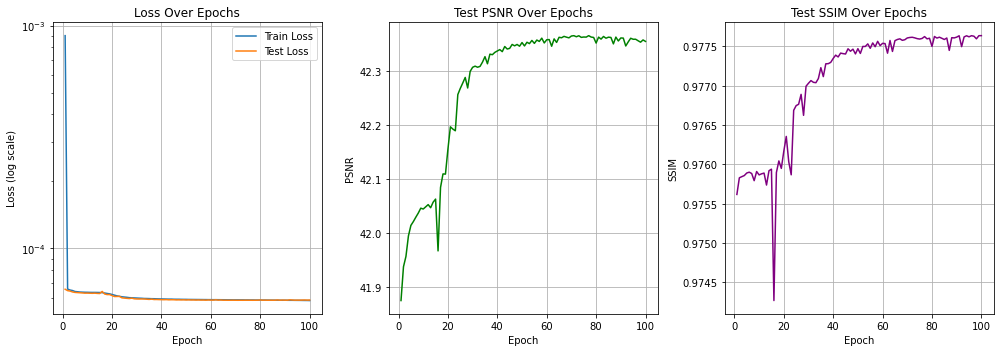

Metrics saved to: 3A_runs/run_20250401_185741/metrics.csv


In [14]:
EPOCHS = 100

run_dir = create_run_dir()
log_and_print = setup_logger(run_dir)

log_and_print("Starting new training run...")
log_and_print(f"Run directory: {run_dir}")

train_losses = []
test_losses = []
test_mses = []
test_psnrs = []
test_ssims = []


for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        lr_imgs, hr_imgs = lr_imgs.cuda(), hr_imgs.cuda()

        lr_imgs = F.interpolate(lr_imgs, size=(150, 150), mode='bilinear', align_corners=False)

        optimizer.zero_grad()
        outputs = model(lr_imgs)
        
        loss = nn.MSELoss()(outputs, hr_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    test_loss, test_mse, test_psnr, test_ssim = evaluate_on_test_set(model, test_loader)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)
    test_mses.append(test_mse)
    test_psnrs.append(test_psnr)
    test_ssims.append(test_ssim)
  
    log_and_print(
        f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.3e} | "
        f"Test Loss = {test_loss:.3e} | MSE = {test_mse:.3e} | PSNR = {test_psnr:.2f} | SSIM = {test_ssim:.4f}")

    if (epoch + 1) % 20 == 0:
        model_path = os.path.join(run_dir, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        log_and_print(f"Saved model at epoch {epoch+1} to {model_path}")

log_and_export_metrics(train_losses, test_losses, test_psnrs, test_ssims, run_dir)

### Load previously trained model

In [ ]:
model.load_state_dict(torch.load('3A.pth'))

### Results

In [16]:
test_loss, test_mse, test_psnr, test_ssim = evaluate_on_test_set(model, test_loader)
print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.3e} | "
        f"Test Loss = {test_loss:.3e} | MSE = {test_mse:.3e} | PSNR = {test_psnr:.2f} | SSIM = {test_ssim:.4f}")

Epoch 100: Train Loss = 5.834e-05 | Test Loss = 5.865e-05 | MSE = 5.861e-05 | PSNR = 42.36 | SSIM = 0.9776


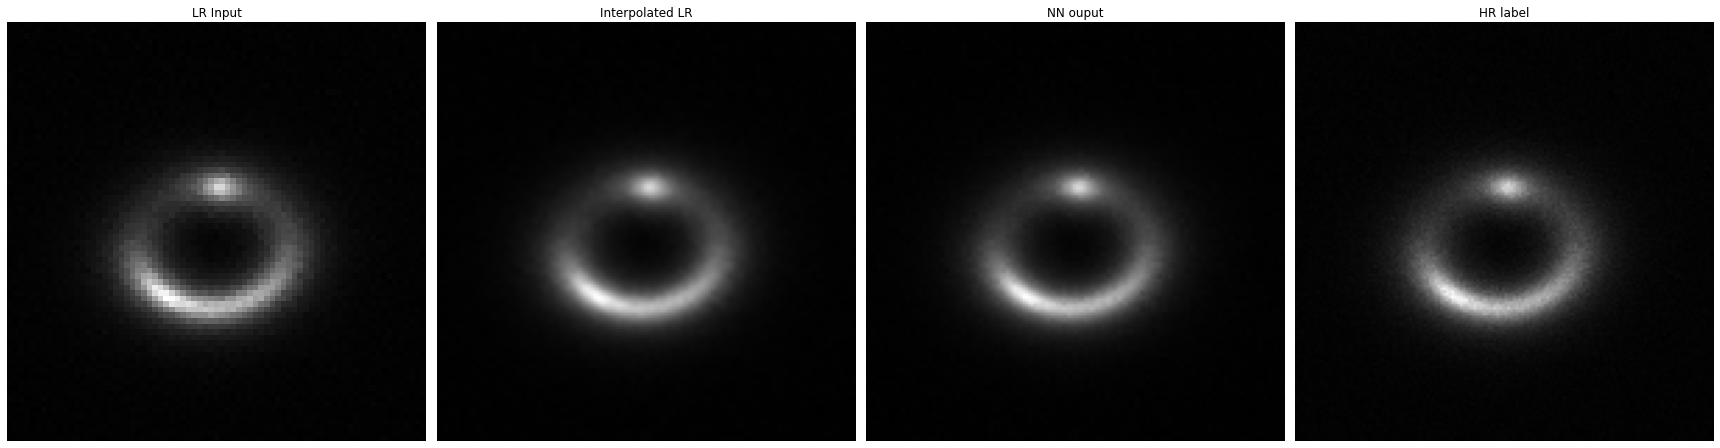

In [23]:
idx = 31
lr, hr = dataset[idx]

lr_img_up = F.interpolate(lr.unsqueeze(0), size=(150, 150), mode='bilinear', align_corners=False)

model.eval()
pred = model(lr_img_up.cuda())


lr_img = lr.squeeze().numpy()
lr_img_up = lr_img_up.squeeze().numpy()
pred = pred.squeeze().cpu().detach().numpy()
hr_img = hr.squeeze().numpy()

fig, axes = plt.subplots(1, 4, figsize=(24, 8))
axes[0].imshow(lr_img, cmap='gray')
axes[0].set_title('LR Input')

axes[1].imshow(lr_img_up, cmap='gray')
axes[1].set_title('Interpolated LR')

axes[2].imshow(pred, cmap='gray')
axes[2].set_title('NN ouput')

axes[3].imshow(hr_img, cmap='gray')
axes[3].set_title('HR label')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### As expected NN did not create drastic improvement, however, surprisingly it seemed to pick up some higher-frequency components
My guess is that potentially LR samples were created through downsampling of HR ones, so they preserved some information about the noise on the original picture